In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# VM_MEASUREMENT. Calculation is probably wrong somewhere...
class VMMeasurement:
    def current_draw(vin):
        # vin units: mV
       return 3*(-0.125*vin/1000 + 2.25), 0.2, np.nan # current draw from (in mA): (12VA, 5VA, 5VD) power supply

    def power_draw(vin):
        return 8*3, 0.9 + 4.5*3, np.nan # all 3 diodes on, all 3 opamps on, ADS1115 in mW from: (12VA, 5VA, 5VD) power supply
    
    def error(vin, r3=1010, r5=990):
        # vin units: mV. Biggest error is from resistors/U7 and everything else is neglible and in uV range, right??
        # vin - g*(0.06+vin) = vin(1 - 0.06*g) - 0.06*g
        g = r5/r3
        u7out = g*(0.06+vin)
        return vin - u7out

In [74]:
VMMeasurement.current_draw(1000), VMMeasurement.power_draw(1), 100*VMMeasurement.error(500)/500

((6.375, 0.2, nan), (24, 14.4, nan), 1.9684356435643622)

Text(0, 0.5, 'Current (mA)')

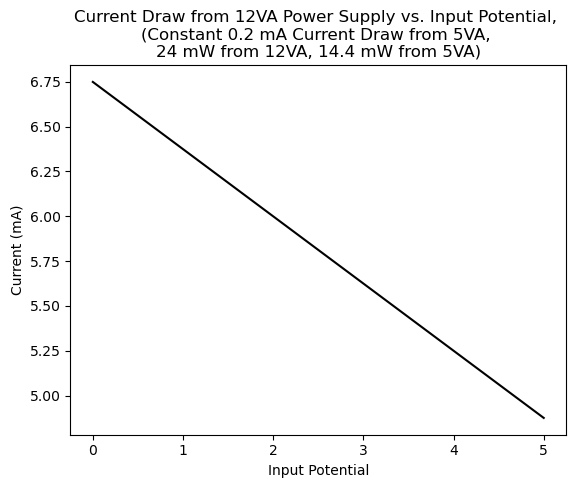

In [75]:
vins = np.linspace(0.5, 5000) # According to ADC, noise floor is around 0.3 mV
plt.title("Current Draw from 12VA Power Supply vs. Input Potential, \n(Constant 0.2 mA Current Draw from 5VA, \n24 mW from 12VA, 14.4 mW from 5VA)")
plt.plot(vins/1000, VMMeasurement.current_draw(vins)[0], 'k', label="Current Draw from 12VA")
plt.xlabel("Input Potential")
plt.ylabel("Current (mA)")

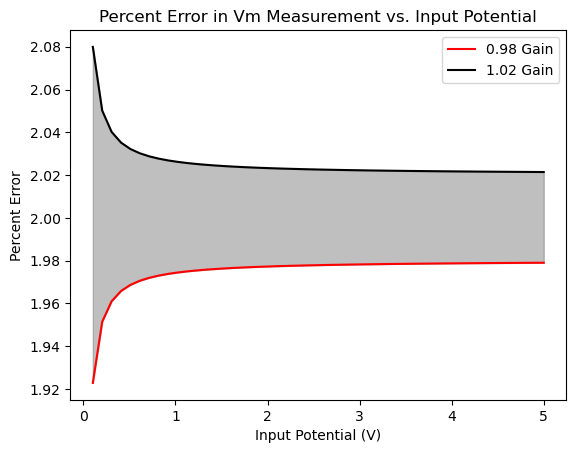

In [107]:
# !!! MAJOR READ FLAGS HERE: WHAT'S GOING ON?? !!!
vins = np.linspace(0.5, 5000) # According to ADC, noise floor is around 0.3 mV
plt.title("Percent Error in Vm Measurement vs. Input Potential")
y3 = np.abs((100*VMMeasurement.error(vins, r3=1010, r5=990)/vins))
y4 = np.abs(100*VMMeasurement.error(vins, r3=990, r5=1010)/vins)
x = (vins/1000)
plt.plot(x[1:], y3[1:], 'r', label="0.98 Gain")
plt.plot(x[1:], y4[1:], 'k', label="1.02 Gain")
plt.fill_between(x[1:], y3[1:], y4[1:], color='grey', alpha=0.5)
#plt.plot(vins/1000, vins, 'r', label="Current Draw from 12VA")
#plt.xscale("log")
plt.xlabel("Input Potential (V)")
plt.ylabel("Percent Error")
plt.legend()

In [97]:
print(y4)

[-14.26262626  -2.07990333  -2.05012564  -2.04016737  -2.03518214
  -2.03218905  -2.03019284  -2.02876658  -2.02769666  -2.02686438
  -2.02619847  -2.02565358  -2.02519947  -2.02481519  -2.0244858
  -2.02420031  -2.02395049  -2.02373005  -2.02353411  -2.02335878
  -2.02320098  -2.02305821  -2.02292841  -2.02280989  -2.02270125
  -2.02260131  -2.02250904  -2.02242361  -2.02234428  -2.02227043
  -2.02220149  -2.022137    -2.02207654  -2.02201975  -2.02196629
  -2.02191589  -2.02186829  -2.02182326  -2.0217806   -2.02174013
  -2.02170168  -2.02166511  -2.02163028  -2.02159707  -2.02156537
  -2.02153507  -2.0215061   -2.02147835  -2.02145177  -2.02142626]


In [155]:
# Current injection measurement

class CurrentInjection:
    def current_draw(iin):
        # vin units: mV
       return np.nan, 1.1, np.nan # current draw from (in mA): (12VA, 5VA, 5VD) power supply

    def power_draw(iin):
        return np.nan, 5.5, np.nan # at a 5V power supply
    
    def error(iin, r8 = 2, r8tol=1, rsh = 0.025, rshtol=5):
        vlow = 1/(1/(((100-r8tol)/100)*r8) + 1/(((100-rshtol)/100)*rsh))*iin # iin in amps
        vhigh = 1/(1/(((100+r8tol)/100)*r8) + 1/(((100+rshtol)/100)*rsh))*iin # iin in amps
        
        resistance_err = np.abs(vhigh - vlow)*1000 # in mV
        ads_err = 1000*0.256*2/2**15 # in mV
        ina282_err = 0.0401/1000 # only considering inherent and added offset voltage from reference
        
        total_v_err = (resistance_err**2 + ads_err**2 + ina282_err**2)**0.5
        total_i_err = total_v_err/(1/(1/(((100-r8tol)/100)*r8) + 1/(((100-rshtol)/100)*rsh)))
        
        return total_i_err
    
CurrentInjection.current_draw(2), CurrentInjection.power_draw(2), CurrentInjection.error(30/1000)
        

((nan, 1.1, nan), (nan, 5.5, nan), 3.195292232731472)

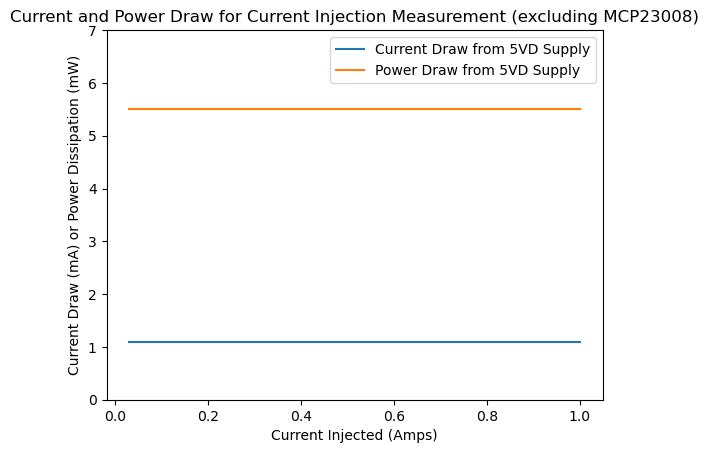

In [160]:
iins = np.linspace(30/1000, 1)
plt.plot(iins, np.zeros(iins.shape) + CurrentInjection.current_draw(iins)[1], label="Current Draw from 5VD Supply")
plt.plot(iins, np.zeros(iins.shape) + CurrentInjection.power_draw(iins)[1], label="Power Draw from 5VD Supply")
plt.ylim(0, 7)
plt.title("Current and Power Draw for Current Injection Measurement (excluding MCP23008)")
plt.xlabel("Current Injected (Amps)")
plt.ylabel("Current Draw (mA) or Power Dissipation (mW)")
plt.legend()

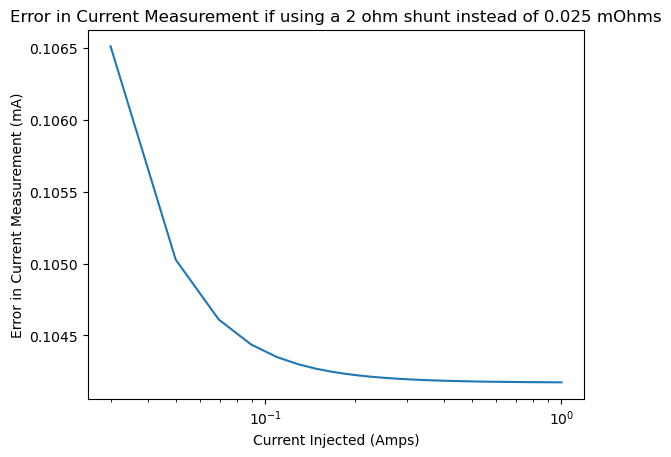

In [165]:
plt.plot(iins, CurrentInjection.error(iins)/(1000*iins), label="Current Draw from 5VD Supply")
plt.title("Error in Current Measurement if using a 2 ohm shunt instead of 0.025 mOhms")
plt.xlabel("Current Injected (Amps)")
plt.ylabel("Error in Current Measurement (mA)")
plt.xscale("log")